In [1]:
##Submission-Machine Learning untuk Pemula

#Nama: Albert Budi Christian
#Email: albert.christian92@gmail.com



In [2]:
#Pertama-tama set runtime setting to GPU pada google colabs agar dapat di run menggunakan GPU, sebab jika training menggunakan CPU akan consume time
#Runtime-> Change Runtime type
#Cek apakah sudah menggunakan GPU atau belum

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#Cek GPU apa yang digunakan
!nvidia-smi

Sat Oct 24 11:07:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |    227MiB / 15079MiB |      6%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Import Library yang dibutuhkan
#Saya menggunakan modul sesuai yang diajarkan ditambah implementasi callback

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import shutil
import random

from keras.optimizers import Adam, Adamax
from keras.applications import MobileNetV2
from keras.models import Sequential,Input,Model
from keras.applications.xception import Xception
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler


In [5]:
#Download Dataset Rock paper scissor
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-10-24 11:07:56--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.63MB/s    in 46s     

2020-10-24 11:08:43 (6.64 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [6]:
# ekstract dataset rockpaperscissor
zip_file = '/tmp/rockpaperscissors.zip'
zip_obj = zipfile.ZipFile(zip_file, 'r')
zip_obj.extractall('/tmp')
zip_obj.close()

In [7]:
#hapus folder rps-cv-images untuk menghindari duplikasi data
dir_path = '/tmp/rockpaperscissors/rps-cv-images'
try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

In [8]:
#set base dir
base_dir = '/tmp/rockpaperscissors'


In [9]:
#memisahkan data training dan data validasi, sesuai ketentuan data validasi sebanyak 40%.

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.4,
                                                                  rescale=1./255,
                                                                  rotation_range=20,
                                                                  shear_range = 0.2,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  fill_mode = 'nearest')
data_train = image_generator.flow_from_directory(directory=base_dir,
                                                     target_size = (224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     shuffle=True,
                                                     subset='training')
data_val = image_generator.flow_from_directory(directory=base_dir,
                                                   target_size = (224,224),
                                                   batch_size=32,
                                                   class_mode = 'categorical',
                                                   shuffle=True,
                                                   subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [10]:
model_base = MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
model = Sequential()
model.add(model_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.5))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [11]:
#Set parameter Call back
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    save_freq="epoch",
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "log_datatrain.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,csvlogger,reduce]

In [12]:
#set learning schedule dengan optimizer Adamax
lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = Adamax(learning_rate=lr_schedule,beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [13]:
#Simpan hasil training ke dalam variabel history
history = model.fit_generator(
    data_train,
    steps_per_epoch  = 25,
    validation_data  = data_val,
    validation_steps = 5,
    epochs = 25,
    verbose = 2,
    callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25

Epoch 00001: val_loss improved from inf to 4.03457, saving model to ./base.model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./base.model/assets
25/25 - 35s - loss: 0.1233 - accuracy: 0.9287 - val_loss: 4.0346 - val_accuracy: 0.2937
Epoch 2/25

Epoch 00002: val_loss improved from 4.03457 to 2.82169, saving model to ./base.model
INFO:tensorflow:Assets written to: ./base.model/assets
25/25 - 34s - loss: 0.0236 - accuracy: 0.9870 - val_loss: 2.8217 - val_accuracy: 0.3375
Epoch 3/25

Epoch 00003: val_loss did not improve from 2.82169
25/25 - 13s - loss: 0.0192 - accuracy: 0.9925 - val_loss: 2.9769 - val_accuracy: 0.3187
Epoch 4/25

Epoch 00004: val_loss improved from 2.82169 to 1.36

In [14]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

Nilai Train loss : 0.11007272452116013
Nilai Akurasi train : 0.9375951290130615
Nilai Test Loss: 0.10466186702251434
Nilai Akurasi Test : 0.9439359307289124
Weights Saved


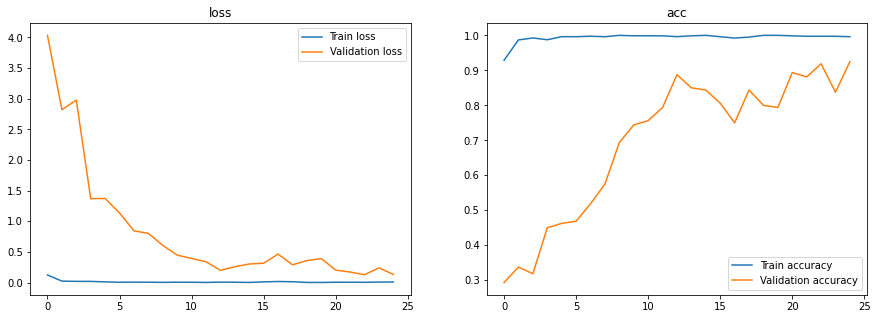

In [15]:
#Cetak grafik dan nilai train dan test

show_final_history(history)
train_score = model.evaluate(data_train, verbose=0)
test_score = model.evaluate(data_val, verbose=0)
print("Nilai Train loss :",train_score[0])
print("Nilai Akurasi train :",train_score[1])
print("Nilai Test Loss:",test_score[0])
print("Nilai Akurasi Test :",test_score[1])

#save model   
model.save("model.h5")
print("Weights Saved")

Saving images.jpg to images (1).jpg
images.jpg


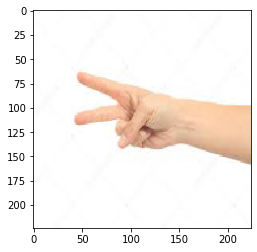

In [19]:
# Test model

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x=x/255
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)

In [20]:
#Hasil deteksi
labels = data_train.class_indices
labels = dict((v,k) for k,v in labels.items())
pred_result = labels[np.argmax(classes)]
print("Tangan terdeteksi:",pred_result)

Tangan terdeteksi: scissors
